# First run eda_customers!

In [1]:
# How many rows are there in tx?

import pandas as pd
tx = pd.read_parquet("../data/processed/transactions_canonical.parquet")
a = pd.read_parquet("../data/processed/articles_clean.parquet", columns=["sku", "groupId", 'category', 'brand'])
tx = tx.drop(columns=["invoiceEmail", "orderLineId"], errors="ignore")



In [2]:
print(len(tx))

312079


In [3]:
# ensure sku column names match in both frames; rename if needed
# tx = tx.rename(columns={'articleSku':'sku'})  # example if needed

cols = ["groupId", "sku", "category", "brand"]
a_dedup = a[cols].drop_duplicates(subset=["groupId", "sku"])

tx = tx.merge(
    a_dedup,
    on=["groupId", "sku"],
    how="left",
    validate="many_to_one"  # raises if a still has duplicate (groupId, sku)
)


In [4]:
print(len(tx))

312079


In [5]:
tx.dtypes


orderId                object
shopUserId             object
created                object
currencyId             object
sku                    object
groupId                object
quantity               object
price                  object
name                   object
type                   object
invoiceCity    string[python]
category       string[python]
brand          string[python]
dtype: object

In [6]:
tx.isna().mean()

orderId        0.000000
shopUserId     0.000000
created        0.000000
currencyId     0.000000
sku            0.000000
groupId        0.000000
quantity       0.000000
price          0.000000
name           0.000000
type           0.000000
invoiceCity    0.000000
category       0.278776
brand          0.278776
dtype: float64

In [7]:
# Output rows where the price value is 6 digits or more
six_digit_price_rows = tx[tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6,}')]
six_digit_price_rows

# For rows where price is exactly 6 digits, set price to the last 3 digits (e.g., 449399.0 -> 399.0)
mask_six_digit = tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6}')
# Fix prices in-place for those rows
def fix_six_digit_price(val):
    s = str(val).strip().replace('.0', '')
    if len(s) == 6 and s.isdigit():
        return float(s[-3:])
    return val

tx.loc[mask_six_digit, 'price'] = tx.loc[mask_six_digit, 'price'].apply(fix_six_digit_price)


# Drop rows where both category and brand are NA as those are internal tx related to delivery

In [8]:

tx = tx[~(tx['category'].isna() & tx['brand'].isna())]


In [9]:
print(len(tx))

225079


## Remove known bugs

In [10]:
# Keep only rows where 'created' date is on or after 2024-06-01 to avoid migration bugs
tx['created'] = pd.to_datetime(tx['created'], errors='coerce')
tx = tx[tx['created'] >= pd.to_datetime('2024-06-01')]

In [11]:
print(len(tx))

222876


In [12]:
tx.head()

,orderId,shopUserId,created,currencyId,sku,groupId,quantity,price,name,type,invoiceCity,category,brand
0,869808,912267,2025-10-06 14:50:27,134,280056-0038,280056,1,1500,Vinterkänga med dubb,telephone,Svärdsjö,"Skor,Skor & tofflor",Åshild
1,869796,912257,2025-10-06 14:44:44,134,260810-2090,260802,1,499,Bh utan bygel Broderie Anglaise,telephone,Lidköping,"Bh utan bygel,Bh,Underkläder",Miss Mary
2,869792,418342,2025-10-06 14:38:56,40,210774-5254,210773,1,318,Top,telephone,Bevtoft,"Överdelar,Toppar",Åshild
3,869792,418342,2025-10-06 14:38:56,40,210784-5254,210784,1,318,Tunika,telephone,Bevtoft,"Överdelar,Tunikor",Åshild
4,869792,418342,2025-10-06 14:38:56,40,200975,200975,1,49,Taske,telephone,Bevtoft,"Accessoarer,Väskor",Åshild


## Unify currenies to SEK for price bucketing

In [13]:
import pandas as pd
import requests

currencyid_to_country = {
    "40":  "DK",
    "134": "SE",
    "103": "NO",
    "50":  "FI",
}

def fetch_sek_rates():
    resp = requests.get(
        "https://api.frankfurter.app/latest",
        params={"from": "EUR", "to": "SEK,DKK,NOK"},
        timeout=10,
    )
    resp.raise_for_status()
    rates = resp.json()["rates"]
    sek_per_eur = rates["SEK"]
    dkk_per_eur = rates["DKK"]
    nok_per_eur = rates["NOK"]
    return {
        "DK": sek_per_eur / dkk_per_eur,
        "NO": sek_per_eur / nok_per_eur,
        "SE": 1.0,
        "FI": sek_per_eur,
    }

tx["currencyId"] = tx["currencyId"].astype("string").str.strip()
tx["currency_country"] = tx["currencyId"].map(currencyid_to_country)
conversion_rates = fetch_sek_rates()
tx["sek_rate"] = tx["currency_country"].map(conversion_rates)
tx["price"] = pd.to_numeric(tx["price"], errors="coerce")
tx["price_sek"] = (tx["price"] * tx["sek_rate"]).round(0).astype("Int64")


Price (SEK) statistics (1st to 99th percentile):
  Count: 218,452
  Mean: 293.84
  Median: 230.00
  Std: 198.43
  Min (1st percentile): 28.00
  Max (99th percentile): 1,158.00


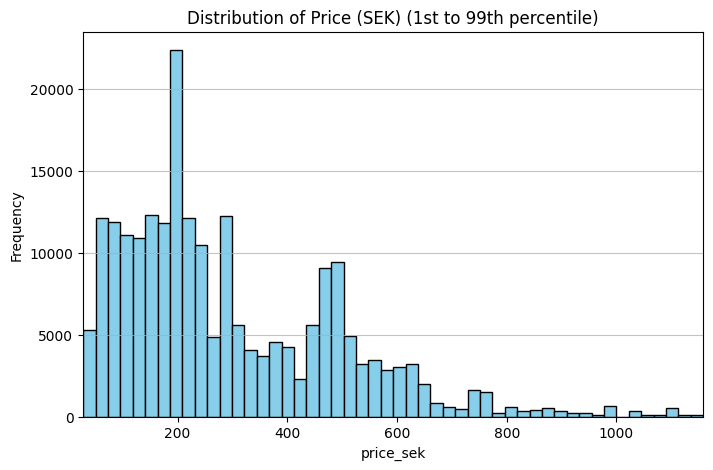

In [14]:
import matplotlib.pyplot as plt

# Show key statistics in numbers
price_sek = tx["price_sek"].dropna()
q_low = price_sek.quantile(0.01)
q_high = price_sek.quantile(0.99)
price_sek_trimmed = price_sek[(price_sek >= q_low) & (price_sek <= q_high)]

print("Price (SEK) statistics (1st to 99th percentile):")
print(f"  Count: {price_sek_trimmed.count():,}")
print(f"  Mean: {price_sek_trimmed.mean():,.2f}")
print(f"  Median: {price_sek_trimmed.median():,.2f}")
print(f"  Std: {price_sek_trimmed.std():,.2f}")
print(f"  Min (1st percentile): {q_low:,.2f}")
print(f"  Max (99th percentile): {q_high:,.2f}")

plt.figure(figsize=(8, 5))
plt.hist(
    price_sek_trimmed, 
    bins=50, 
    color="skyblue", 
    edgecolor="black"
)
plt.title("Distribution of Price (SEK) (1st to 99th percentile)")
plt.xlabel("price_sek")
plt.ylabel("Frequency")
plt.xlim(q_low, q_high)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [15]:
# Read the cleaned customers data from Parquet, do not change dtypes
customers = pd.read_parquet("../data/processed/customers_clean.parquet")

# Merge the 'Age' and 'invoiceCity' columns from the customers dataframe into the transactions dataframe, matching on 'shopUserId'
# This adds the 'Age' and 'invoiceCity' information for each transaction, using a left join to keep all transactions
tx = tx.merge(customers[["shopUserId", "Age", "Gender"]], on="shopUserId", how="left")

In [16]:
# Keep customers where age is between 10 and 105, or where age is NaN
tx = tx[
    (tx['Age'].isna()) |
    ((tx['Age'] <= 105) & (tx['Age'] >= 10))
]

In [17]:
tx.isna().mean()

orderId             0.000000
shopUserId          0.000000
created             0.000000
currencyId          0.000000
sku                 0.000000
groupId             0.000000
quantity            0.000000
price               0.000000
name                0.000000
type                0.000000
invoiceCity         0.000000
category            0.000000
brand               0.000000
currency_country    0.000000
sek_rate            0.000000
price_sek           0.000000
Age                 0.360828
Gender              0.360828
dtype: float64

In [18]:
print("Unique values in 'type' column:", tx["type"].unique())


Unique values in 'type' column: ['telephone' 'web' 'email' 'letter' 'other']


# Line price

In [19]:
# Convert 'quantity' to numeric, round to nearest integer, and convert back to string (if needed)
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce").round().astype("Int64").astype(str)


In [20]:
print("Unique values of quantity:", tx["quantity"].unique())


Unique values of quantity: ['1' '2' '3' '4' '10' '6' '5' '7' '12' '16' '9' '11' '8' '50' '15' '176'
 '130' '19' '20' '229' '14']


In [21]:
# Calculate line_total_sek as price_sek * quantity, ensuring both are numeric, rounded to nearest integer (no decimals), and drop rows where result is NA or 0
tx["price_sek"] = pd.to_numeric(tx["price_sek"], errors="coerce")
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce")
tx["line_total_sek"] = (tx["price_sek"] * tx["quantity"]).round()
# Ensure line_total_sek is numeric
tx["line_total_sek"] = pd.to_numeric(tx["line_total_sek"], errors="coerce")
# Drop rows where line_total_sek is NA or 0
tx = tx.dropna(subset=["line_total_sek"])
tx = tx[tx["line_total_sek"] != 0]


# Country remap COUNTRY_MAP_ALPHA = {"SE": "Sweden", "DK": "Denmark", "FI": "Finland", "NO": "Norway"}

In [22]:
COUNTRY_MAP_ALPHA = {"SE": "Sweden", "DK": "Denmark", "FI": "Finland", "NO": "Norway"}
tx["country"] = tx["currency_country"].map(COUNTRY_MAP_ALPHA).fillna(tx["currency_country"])
tx = tx.drop(columns=["currency_country"])


In [23]:
print("Number of unique shopUserId:", tx['shopUserId'].nunique())


Number of unique shopUserId: 56841


In [24]:
# Save cleaned transactions to Parquet without changing dtypes
tx.to_parquet("../data/processed/transactions_clean.parquet", index=False)

In [25]:
# Output the proportion of NA (missing) values for each column in tx
print(tx.isna().mean())


orderId           0.000000
shopUserId        0.000000
created           0.000000
currencyId        0.000000
sku               0.000000
groupId           0.000000
quantity          0.000000
price             0.000000
name              0.000000
type              0.000000
invoiceCity       0.000000
category          0.000000
brand             0.000000
sek_rate          0.000000
price_sek         0.000000
Age               0.360878
Gender            0.360878
line_total_sek    0.000000
country           0.000000
dtype: float64
